In [17]:
import pandas as pd
from langdetect import detect
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df1 = pd.read_csv("../data/wikidata_artists_part1.csv")
df2= pd.read_csv("../data/wikidata_artists_part2.csv")

df = pd.concat([df1, df2], ignore_index=True)
df.head()


,artist,country,award,death,gender
0,13,NaN,álbum,NaN,Unknown
1,13,NaN,album de diamant du SNEP,NaN,Unknown
2,13,NaN,תואר יהלום מ-SNEP,NaN,Unknown
3,13,NaN,diamantalbum enligt SNEP,NaN,Unknown
4,13,NaN,diamantni album SNEP,NaN,Unknown


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187507 entries, 0 to 187506
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   artist   187507 non-null  object
 1   country  157000 non-null  object
 2   award    187507 non-null  object
 3   death    67924 non-null   object
 4   gender   187507 non-null  object
dtypes: object(5)
memory usage: 7.2+ MB


In [4]:
df.shape

(187507, 5)

In [5]:
df.isna().sum()

artist          0
country     30507
award           0
death      119583
gender          0
dtype: int64

In [6]:
df['death'] = df['death'].notna()
df['death'] = df['death'].map({False: 'alive', True: 'deceased'})
df['death'].value_counts()

death
alive       119583
deceased     67924
Name: count, dtype: int64

In [7]:
df.isna().sum()

artist         0
country    30507
award          0
death          0
gender         0
dtype: int64

In [8]:
df['country'] = df['country'].fillna('Unknown')

### Duplicated

In [9]:
df.duplicated().sum()

np.int64(46974)

In [ ]:
df = df.drop_duplicates()

In [11]:
df.shape

(140533, 5)

In [12]:
# Frases o palabras comunes en otros idiomas
palabras_no_ingles = [
    "stär um", "para", "prêmio", "premio", "prix", "voor", "de", "sus", "la", "das", "del", "der", "des",
    "el", "le", "pe", "stella", "sulla", "nagroda", "carriera", "réalta", "premi", "xelata",
    "tähti", "æresdoktor", "famen", "doktor", "oriel", "anfarwolion", "auf dem", "or merit", "kpakpando", "stäär üüb"
    
]

# Caché para langdetect
award_lang_cache = {}

def is_english_filtered(text):
    text_l = str(text).lower().strip()
    
    if text not in award_lang_cache:
        try:
            award_lang_cache[text] = detect(text)
        except:
            award_lang_cache[text] = "unknown"
    
    if award_lang_cache[text] != "en":
        return False

    for palabra in palabras_no_ingles:
        if palabra in text_l:
            return False

    return True

# Aplicar el filtro sobre la columna 'award'
tqdm.pandas(desc="Filtrando premios válidos")
df = df[df['award'].notna() & df['award'].progress_apply(is_english_filtered)]

df.head()

Filtrando premios válidos: 100%|██████████| 140533/140533 [02:02<00:00, 1151.87it/s]


,artist,country,award,death,gender
60,1995,Unknown,Victory of the album of urban musics,alive,Unknown
69,50 Cent,United States,Billboard Music Awards,alive,male
73,50 Cent,United States,Billboard Music Award,alive,male
251,50 Cent,United States,star on Hollywood Walk of Fame,alive,male
278,5 Seconds of Summer,Unknown,American Music Award for New Artist of the Year,alive,Unknown


In [14]:
df.shape

(4365, 5)

In [15]:
# Función para obtener el valor más frecuente (o un valor válido si no hay modo)
def valor_mas_comun(serie):
    if not serie.mode().empty:
        return serie.mode().iloc[0]
    elif not serie.dropna().empty:
        return serie.dropna().iloc[0]
    else:
        return None

# Agrupar por artista y consolidar la información más representativa
df = df.groupby("artist").agg({
    "country": valor_mas_comun,
    "death": valor_mas_comun,
    "gender": valor_mas_comun,
    "award": lambda x: sorted(set(x))  # Lista de premios únicos
}).reset_index()

# Número total de premios únicos
df["award_count"] = df["award"].apply(len)

# Columna binaria: ¿ganó un Grammy?
df["won_grammy"] = df["award"].apply(
    lambda premios: any("grammy" in str(premio).lower() for premio in premios)
)

# Convertir la lista de premios a un solo string (opcional, para exportación o presentación)
df["awards_list"] = df["award"].apply(lambda x: "; ".join(x))

# Reorganizar columnas para visualización clara
df = df[[
    "artist", "gender", "country", "death", "award_count",
    "won_grammy", "awards_list"
]]

# Vista previa del resultado
df.head()

,artist,gender,country,death,award_count,won_grammy,awards_list
0,1995,Unknown,Unknown,alive,1,False,Victory of the album of urban musics
1,5 Seconds of Summer,Unknown,Unknown,alive,2,False,American Music Award for New Artist of the Yea...
2,50 Cent,male,United States,alive,3,False,Billboard Music Award; Billboard Music Awards;...
3,A Tribe Called Quest,Unknown,Unknown,alive,4,False,BRIT Awards/International Group; Brit Award fo...
4,ABBA,Unknown,Unknown,alive,4,False,First prize of the Eurovision Song Contest; Ro...


In [16]:
df.shape

(1131, 7)

### Graphics

C:\Users\natym\AppData\Local\Temp\ipykernel_14084\171544419.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_premiados, y="artist", x="award_count", palette="viridis")
C:\Users\natym\AppData\Local\Temp\ipykernel_14084\171544419.py:8: UserWarning: Glyph 127894 (\N{MILITARY MEDAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\natym\Desktop\Workshop_002\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127894 (\N{MILITARY MEDAL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


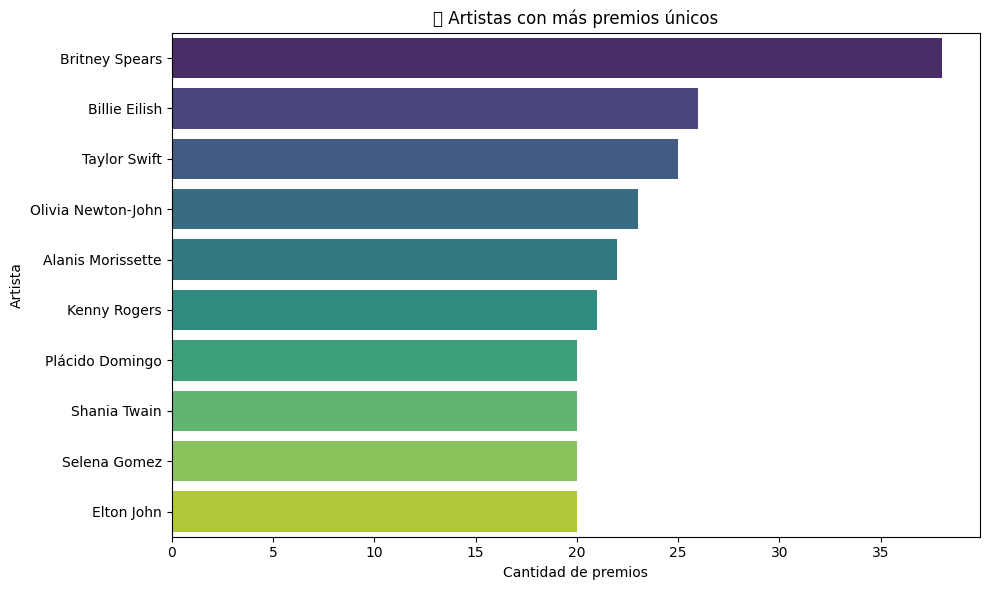

In [18]:
top_premiados = df.sort_values(by="award_count", ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_premiados, y="artist", x="award_count", palette="viridis")
plt.title("🎖️ Artistas con más premios únicos")
plt.xlabel("Cantidad de premios")
plt.ylabel("Artista")
plt.tight_layout()
plt.show()

C:\Users\natym\AppData\Local\Temp\ipykernel_14084\745045084.py:7: UserWarning: Glyph 127758 (\N{EARTH GLOBE AMERICAS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\natym\Desktop\Workshop_002\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127758 (\N{EARTH GLOBE AMERICAS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


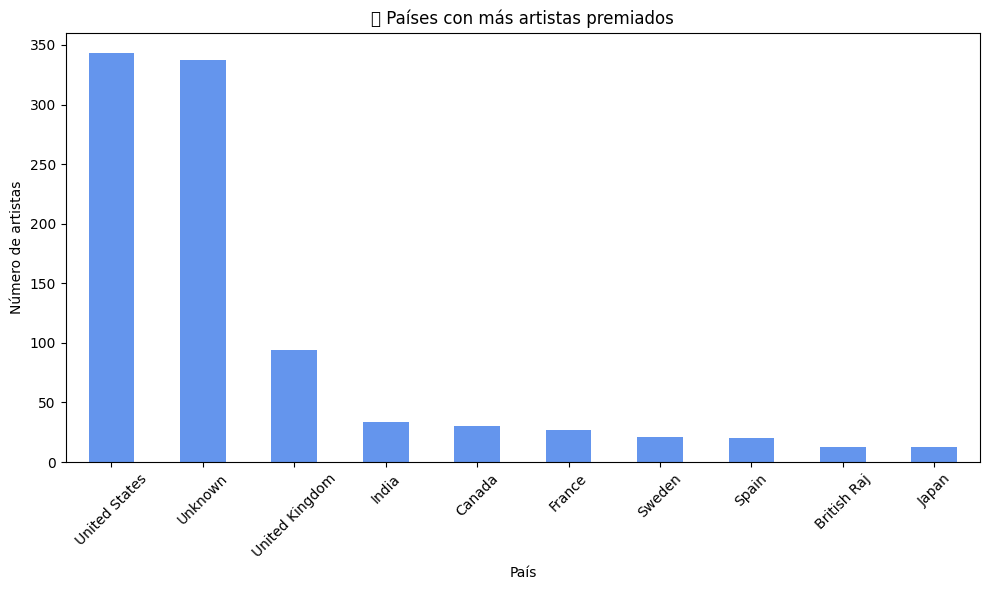

In [20]:
plt.figure(figsize=(10, 6))
df["country"].value_counts().head(10).plot(kind="bar", color="cornflowerblue")
plt.title("🌎 Países con más artistas premiados")
plt.ylabel("Número de artistas")
plt.xlabel("País")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\natym\AppData\Local\Temp\ipykernel_14084\2306415157.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="won_grammy", palette="Set2")
C:\Users\natym\AppData\Local\Temp\ipykernel_14084\2306415157.py:7: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\natym\Desktop\Workshop_002\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


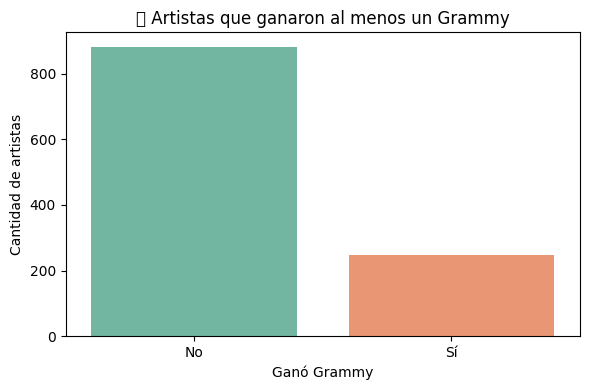

In [24]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="won_grammy", palette="Set2")
plt.title("🏆 Artistas que ganaron al menos un Grammy")
plt.xticks([0, 1], ["No", "Sí"])
plt.xlabel("Ganó Grammy")
plt.ylabel("Cantidad de artistas")
plt.tight_layout()
plt.show()

C:\Users\natym\AppData\Local\Temp\ipykernel_14084\1313215325.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="death", palette="coolwarm")


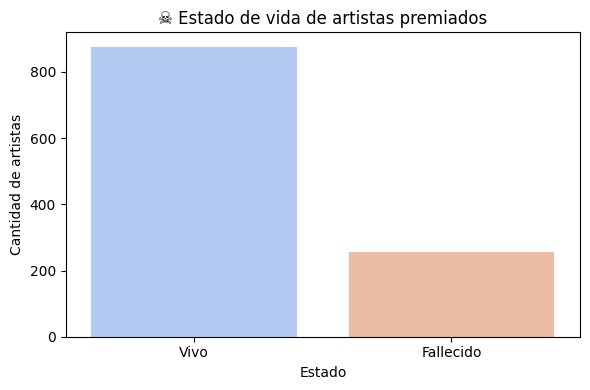

In [27]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="death", palette="coolwarm")
plt.title("☠️ Estado de vida de artistas premiados")
plt.xticks(['alive', 'deceased'], ['Vivo', 'Fallecido'])
plt.xlabel("Estado")
plt.ylabel("Cantidad de artistas")
plt.tight_layout()
plt.show()

C:\Users\natym\AppData\Local\Temp\ipykernel_14084\3654576147.py:6: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\natym\Desktop\Workshop_002\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


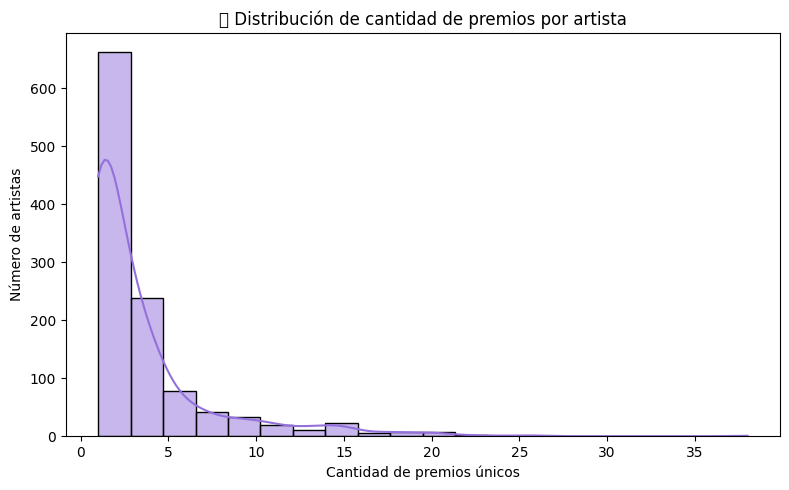

In [28]:
plt.figure(figsize=(8, 5))
sns.histplot(df["award_count"], bins=20, kde=True, color="mediumpurple")
plt.title("🎯 Distribución de cantidad de premios por artista")
plt.xlabel("Cantidad de premios únicos")
plt.ylabel("Número de artistas")
plt.tight_layout()
plt.show()

C:\Users\natym\AppData\Local\Temp\ipykernel_14084\1016379674.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=premios_por_pais.values, y=premios_por_pais.index, palette="Blues_d")
C:\Users\natym\AppData\Local\Temp\ipykernel_14084\1016379674.py:8: UserWarning: Glyph 127941 (\N{SPORTS MEDAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\natym\Desktop\Workshop_002\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127941 (\N{SPORTS MEDAL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


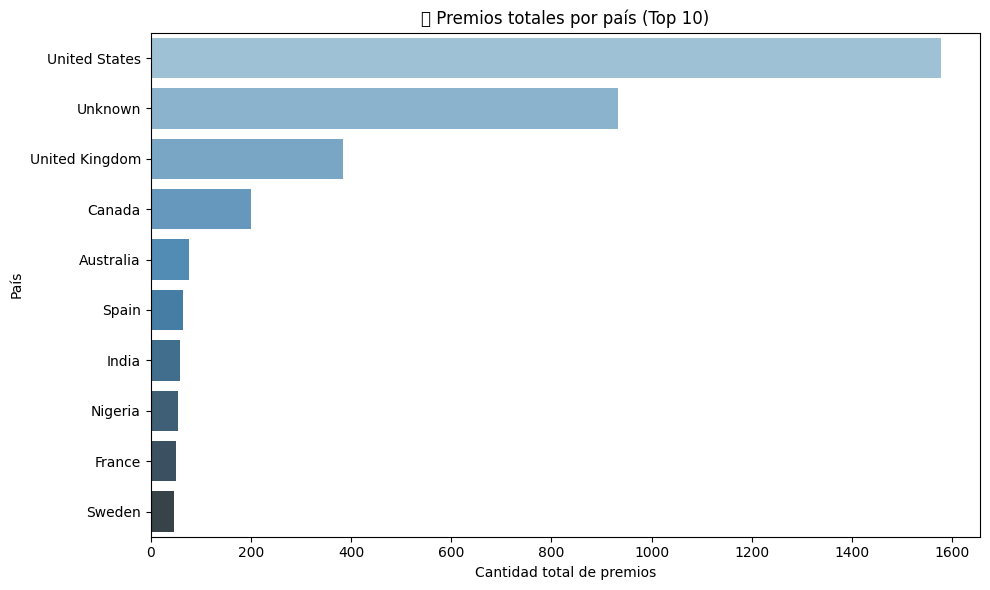

In [29]:
premios_por_pais = df.groupby("country")["award_count"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=premios_por_pais.values, y=premios_por_pais.index, palette="Blues_d")
plt.title("🏅 Premios totales por país (Top 10)")
plt.xlabel("Cantidad total de premios")
plt.ylabel("País")
plt.tight_layout()
plt.show()

C:\Users\natym\AppData\Local\Temp\ipykernel_14084\3127638338.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=grammy_por_genero.index, y=grammy_por_genero.values, palette="Set2")
C:\Users\natym\AppData\Local\Temp\ipykernel_14084\3127638338.py:8: UserWarning: Glyph 127908 (\N{MICROPHONE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\natym\Desktop\Workshop_002\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127908 (\N{MICROPHONE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


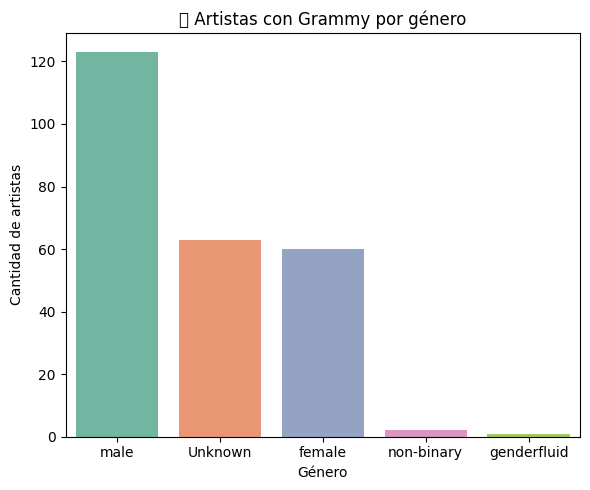

In [30]:
grammy_por_genero = df[df["won_grammy"] == True]["gender"].value_counts()

plt.figure(figsize=(6, 5))
sns.barplot(x=grammy_por_genero.index, y=grammy_por_genero.values, palette="Set2")
plt.title("🎤 Artistas con Grammy por género")
plt.xlabel("Género")
plt.ylabel("Cantidad de artistas")
plt.tight_layout()
plt.show()

C:\Users\natym\AppData\Local\Temp\ipykernel_14084\1732291256.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=fallecidos_pais.index, x=fallecidos_pais.values, palette="Reds")


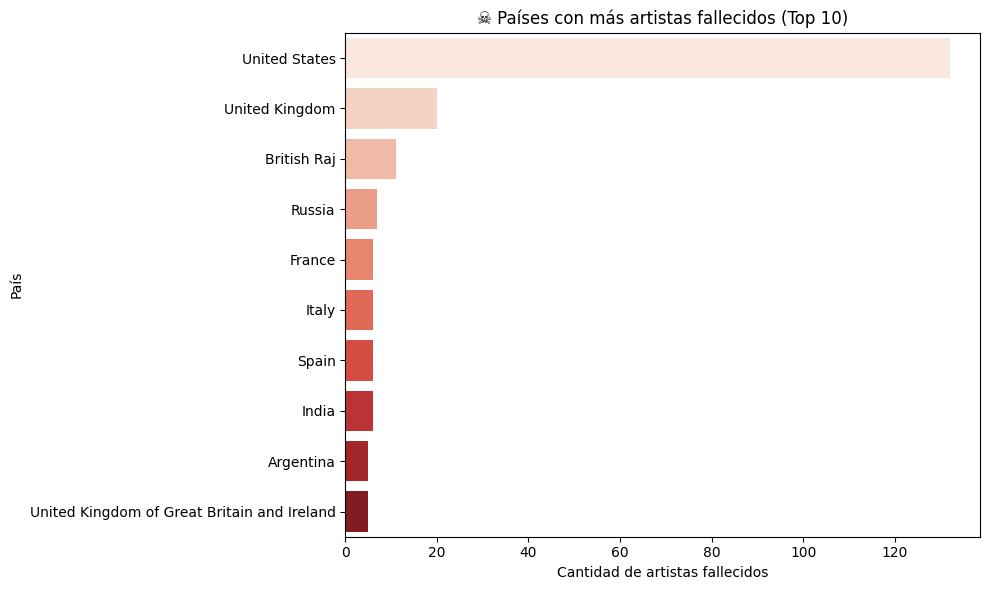

In [32]:
fallecidos_pais = df[df["death"] == 'deceased']["country"].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(y=fallecidos_pais.index, x=fallecidos_pais.values, palette="Reds")
plt.title("☠️ Países con más artistas fallecidos (Top 10)")
plt.xlabel("Cantidad de artistas fallecidos")
plt.ylabel("País")
plt.tight_layout()
plt.show()